In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import h5py
import pickle
import pandas
import matplotlib.pyplot as plt
#import deepdish.io as io
import tensorflow as tf
#tf.enable_eager_execution()
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from keras.utils import plot_model
from keras.models import load_model
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from ROOT import TLorentzVector
from matplotlib.colors import LogNorm
#from skhep.math import LorentzVector
import random
#tf.enable_eager_execution()

Using TensorFlow backend.


Welcome to JupyROOT 6.16/00


In [2]:
tf.__version__

'2.3.0'

In [2]:
!ls /lcg/storage13/atlas/gupta/stealth_boson

Zp2200-S80A15.h5  Zp3300m1_S400A80.h5  Zp3300_S400A80.h5
Zp2200_S80A30.h5  Zp3300m1_S400VV.h5


In [3]:
f_Zboson=h5py.File('/lcg/storage13/atlas/gupta/stealth_boson/Zp2200-S80A15.h5','r')

In [4]:
f_Zboson.keys()

<KeysViewHDF5 ['high_level', 'objects', 'partons']>

In [5]:
# Constituents of leading jet in an event
len(f_Zboson["objects/jets/constituents"][0,0])

185

In [6]:
# Total no. of events
len(f_Zboson["objects/jets/constituents"][:,0])

97579

In [7]:
# QCD data
f_QCD=h5py.File('/lcg/storage13/atlas/martinj/h5/pp_jj/final_jj_1MEvents.h5','r')

In [8]:
# Constituents of leading jet in an event
f_QCD.keys()

<KeysViewHDF5 ['high_level', 'objects', 'partons']>

In [9]:
# Constituents of leading jet in an event
len(f_QCD["objects/jets/constituents"][0,0])

80

In [10]:
# Total no. of events
len(f_QCD["objects/jets/constituents"][:,0])

705643

In [11]:
!ls /lcg/storage13/atlas/martinj/h5/pp_tt

final_merging_script_tt.py  final_tt_500kEvents.h5


In [12]:
# tt_bar data
f_ttbar=h5py.File('/lcg/storage13/atlas/martinj/h5/pp_tt/final_tt_500kEvents.h5','r')

In [13]:
# Constituents of leading jet in an event
len(f_ttbar["objects/jets/constituents"][0,0])

505

In [14]:
# Total no. of events
len(f_ttbar["objects/jets/constituents"][:,0])

320124

In [15]:
train_data = '/lcg/storage13/atlas/martinj/h5/pp_jj/final_jj_1MEvents.h5'
test_data = '/lcg/storage13/atlas/martinj/h5/pp_tt/final_tt_500kEvents.h5'
outlier = '/lcg/storage13/atlas/gupta/stealth_boson/Zp2200-S80A15.h5'

In [16]:
def ExyzToEtaPhiPtE(fourvectors):
    '''Convert collection of jet constituent fourvectors from Epxpypz representation to EtaPhiPtE.
    Input array fourvectors must be of shape (nJets,nConstituent,4), with fourvector ordered E,px,py,pz.
    Returns same shape but with fourvector ordered eta,phi,pT,E.'''
    
    nconst = fourvectors.shape[1]
    pt = np.sqrt(np.sum(np.power(fourvectors[:,:,1:3],2),axis=-1))
    p =  np.sqrt(np.sum(np.power(fourvectors[:,:,1:],2),axis=-1))
    eta = -0.5*np.log( (1 - fourvectors[:,:,3] / p)/(1+fourvectors[:,:,3] / p)) #need to implement case of pz == 0 (eta = 0)
    try:
        eta[(fourvectors[:,:,-1].mask) | (fourvectors[:,:,-1] == 0)] = 0
    except:
        eta[(fourvectors[:,:,-1] == 0)] = 0
    phi = np.arctan2(fourvectors[:,:,2], fourvectors[:,:,1])
    e = fourvectors[:,:,0]
    
    phi = np.where(phi > np.pi, phi - 2*np.pi, phi)
    phi = np.where(phi <= -np.pi, phi + 2*np.pi, phi)

    return np.ma.concatenate([
        eta.reshape(-1,nconst,1),
        phi.reshape(-1,nconst,1),
        pt.reshape(-1,nconst,1),
        e.reshape(-1,nconst,1)
    ],axis=-1)

def EtaPhiPtEToXyzE(fourvectors):
    nconst = fourvectors.shape[1]
    #pt = np.sqrt(np.sum(np.power(fourvectors[:,:,1:3],2),axis=-1))
    #p =  np.sqrt(np.sum(np.power(fourvectors[:,:,1:],2),axis=-1))
    #eta = -0.5*np.log( (1 - fourvectors[:,:,3] / p)/(1+fourvectors[:,:,3] / p)) #need to implement case of pz == 0 (eta = 0)
    #eta[(fourvectors[:,:,-1].mask) | (fourvectors[:,:,-1] == 0)] = 0
    #phi = np.arctan2(fourvectors[:,:,2], fourvectors[:,:,1])
    e = fourvectors[:,:,-1]
    px = fourvectors[:,:,2]*np.cos(fourvectors[:,:,1])
    py = fourvectors[:,:,2]*np.sin(fourvectors[:,:,1])
    pz = fourvectors[:,:,2]*np.sinh(fourvectors[:,:,0])
    
    return np.ma.concatenate([
        px.reshape(-1,nconst,1),
        py.reshape(-1,nconst,1),
        pz.reshape(-1,nconst,1),
        e.reshape(-1,nconst,1),
    ],axis=-1)

def transform_jets(jets,jet_pt,jet_e):
    #centre jet on leading pT cluster
    jet_eta = jets[:,0,0]
    jet_phi = jets[:,0,1]

    mask = jets.mask.copy()
    nconst = jets.shape[1]

    #jets = np.ma.masked_where(df.mask,jets)
    jets[:,:,:2] = np.ma.masked_array(np.concatenate([(jets[:,:,0] - jet_eta.reshape(-1,1)).reshape(-1,nconst,1),
                                (jets[:,:,1] - jet_phi.reshape(-1,1)).reshape(-1,nconst,1)], axis=-1),mask=mask[:,:,:2])

    #constraint phi between -pi and pi
    jets[:,:,1] = np.where(jets[:,:,1] < np.pi, jets[:,:,1] + 2*np.pi,jets[:,:,1])
    jets[:,:,1] = np.where(jets[:,:,1] >= np.pi, jets[:,:,1] - 2*np.pi,jets[:,:,1])
    
    #Add fraction pT
    fracs = np.concatenate([(jets[:,:,2] / jet_pt.reshape(-1,1)).reshape(-1,nconst,1), (jets[:,:,3] / jet_e.reshape(-1,1)).reshape(-1,nconst,1)],axis=-1)
    fracs = np.ma.masked_array(fracs,mask=mask[:,:,:2])
    jets = np.ma.concatenate([jets,fracs],axis=-1)

    #Rotate subleading cluster
    alpha = - np.arctan2(jets[:,1,1],jets[:,1,0])
    alpha = np.repeat(alpha,nconst).reshape(-1,nconst)
    jetseta = jets[:,:,0]*np.cos(alpha) - jets[:,:,1]*np.sin(alpha)
    jetsphi = jets[:,:,0]*np.sin(alpha) + jets[:,:,1]*np.cos(alpha)

    #Calculate Centre of P and flip so always positive
    flip = np.sum((jetsphi * jets[:,:,-2]),axis=-1) < 0
    jetsphi = np.ma.where(np.repeat(flip,nconst).reshape(-1,nconst), -1*jetsphi, jetsphi)
    jets[:,:,:2] = np.ma.concatenate([jetseta.reshape(-1,nconst,1),jetsphi.reshape(-1,nconst,1)],axis=-1)

    #Recalculate E in transformed space, assume massless constituents
    emod = jets[:,:,2]*np.cosh(jets[:,:,0])
    fracemod = jets[:,:,4]*np.cosh(jets[:,:,0])
    # if jets.shape[-1] == 3:
    #     jets = jets.dstack(jets,emod.reshape(-1,jets.shape[1],1))
    # elif jets.shape[-1] == 4:
    jets[:,:,3] = emod
    jets[:,:,5] = fracemod

    return jets

In [17]:
def getJetsFromH5(filename,nconst=40,nattr=5,append_subleading=True,return_pxpypzE=False):
    '''Return the training dataset in the form (njets,nconstituents,(dEta,dPhi,pT,E,pT(jet),E(jet))). Columns are assumed to be Four vectors in E,px,py,pz followed by global variables and meta data.
    Additionally returns large radius jet properties: jet_pt, jet_e, jet_deta, for renormalising and transforming.
    Returned shape (njets,nconst,6),njets,njets,njets
    filename: path of the file
    nconst: Number of constituents to take, sorted by pT
    nattr: Number of attributes per jet in the file
    append_subleading: Return leading and subleading jets, concetenated together
    return_pxpypzE: Return jets in the form (njets,constituents,(px,py,pz,E)) instead
    '''
    f = h5py.File(filename,'r')
    jets = f['objects/jets/constituents'][:,0]
    fjet = f['objects/jets/obs'][:,0]
    if append_subleading is True:
        jets = np.concatenate([jets,f['objects/jets/constituents'][:,1]])
        fjet = np.concatenate([fjet,f['objects/jets/obs'][:,1]])

    for _ in map(lambda x: x.resize(nattr*nconst,refcheck=False),jets): pass
    #while map(lambda x: x.resize(nattr*nconst,refcheck=False),jets).__next__(): pass
    jets = np.vstack(jets).reshape(-1,nconst,nattr)
    jets = jets[:,:,:4]

    def EfromPtEtaPhiM(arr):
        pt  = arr[0]
        eta = arr[1]
        phi = arr[2]
        m   = arr[3]
        return np.sqrt((pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 - m*m)
    
    jet_e = np.apply_along_axis(EfromPtEtaPhiM,1,fjet)
    jet_pt = fjet[:,0]

    jets = np.ma.masked_where(jets == [0,0,0,0],jets)
    jets = ExyzToEtaPhiPtE(jets)
 
    jet_deta = jets[:,0,0]
    jets = transform_jets(jets,jet_pt,jet_e)

    if return_pxpypzE == True:
        jets = EtaPhiPtEToXyzE(jets[:,:,:4])

    return jets,jet_pt,jet_e,jet_deta


In [18]:
train_jets, train_jet_pt, _,_ = getJetsFromH5(train_data,nconst=20,append_subleading=False,return_pxpypzE=True)

In [19]:
test_jets, test_jet_pt, _,_ = getJetsFromH5(test_data,nconst=20,append_subleading=False,return_pxpypzE=True)

In [20]:
outlier_jets, outlier_jet_pt, _,_ = getJetsFromH5(outlier,nconst=20,append_subleading=False,return_pxpypzE=True)

In [21]:
lentraindata = len(outlier_jets)
val_jets, val_jet_pt = train_jets[2*lentraindata:3*lentraindata], train_jet_pt[2*lentraindata:3*lentraindata]
train_jets, train_jet_pt = train_jets[:2*lentraindata], train_jet_pt[:2*lentraindata]
test_jets,test_jet_pt = test_jets[:lentraindata], test_jet_pt[:lentraindata]

In [22]:
def etaphipte_to_pxpypze(jet):
    v = TLorentzVector()
    v.SetPtEtaPhiE(*jet[[2,0,1,3]])
    return (v.Px,v.Py,v.Pz,v.E)

def m_from_pxpypze(jet):
    v = TLorentzVector()
    v.SetPxPyPzE(*jet)
    return v.M

def pt_from_pxpypze(jet):
    v = TLorentzVector()
    v.SetPxPyPzE(*jet)
    return v.Pt

In [23]:
def _jetmass_from_const(jetconst,pxpypze=False):
    if pxpypze == False:
        jets_xyz = np.apply_along_axis(etaphipte_to_pxpypze,2,jetconst)
    else:
        jets_xyz = jetconst
    jets_m = np.apply_along_axis(m_from_pxpypze,-1,np.sum(jets_xyz,axis=1))
    return jets_m

In [24]:
train_true_m = _jetmass_from_const(train_jets,pxpypze=True)
train_jets_norm = train_jets / train_jet_pt[::,np.newaxis,np.newaxis]

test_true_m = _jetmass_from_const(test_jets,pxpypze=True)
test_jets_norm = test_jets / test_jet_pt[::,np.newaxis,np.newaxis]

outlier_true_m = _jetmass_from_const(outlier_jets,pxpypze=True)
outlier_jets_norm = outlier_jets / outlier_jet_pt[::,np.newaxis,np.newaxis]

val_true_m = _jetmass_from_const(val_jets,pxpypze=True)
val_jets_norm = val_jets / val_jet_pt[::,np.newaxis,np.newaxis]

In [25]:
def transform_set(x_values,transformers):
    return np.ma.masked_where(x_values.mask,
                              np.dstack([trans.transform(x_values[:,:,i].reshape(-1,1))
                                                                        .reshape(*x_values.shape[:2],1)\
                              for i,trans in enumerate(transformers)]))

In [26]:
transformers = [RobustScaler().fit(train_jets_norm[:,:,i][~train_jets.mask[:,:,i]].reshape(-1,1)) for i in range(train_jets.shape[-1])] 

In [27]:
train_jets_t = transform_set(train_jets_norm,transformers)
train_jets_t  = train_jets_t.reshape(-1,20*4)
outlier_jets_t = transform_set(outlier_jets_norm,transformers)
outlier_jets_t  = outlier_jets_t.reshape(-1,20*4)
test_jets_t = transform_set(test_jets_norm,transformers)
test_jets_t  = test_jets_t.reshape(-1,20*4)
val_jets_t = transform_set(val_jets_norm,transformers)
val_jets_t  = val_jets_t.reshape(-1,20*4)

In [28]:
train_jets_t.shape

(195158, 80)

In [29]:
# concatenating training tshirt , shirt, boot
training_X = np.concatenate((train_jets_t,outlier_jets_t), axis = 0)
training_X = training_X.astype('float32')
# concatenating test tshirt and shoe
testing_X = np.concatenate((val_jets_t,test_jets_t), axis = 0)
testing_X = testing_X.astype('float32')
print("Shape of training dataset: ",training_X.shape)
print("Shape of testing dataset: ",testing_X.shape)

Shape of training dataset:  (292737, 80)
Shape of testing dataset:  (195158, 80)


In [30]:
# generate labels for training dataset tshirt = 0 and trouser = 1
train_y = np.concatenate((np.zeros(len(train_jets_t)), np.ones(len(outlier_jets_t))), axis=0)

# test generate labels for testing dataser tshirt = 0 and shoe = 1
test_y = np.concatenate((np.zeros(len(val_jets_t)), np.ones(len(test_jets_t))), axis=0)

In [31]:
# Shuffling test data
rng = check_random_state(1)
indices_test = rng.permutation(len(testing_X))
testing_X_shuffled = testing_X[indices_test]
test_y_shuffled = test_y[indices_test]

In [32]:
# Create batches of data for training
def create_batch (batch_size):
  anchors = np.zeros((batch_size, 80))
  positives = np.zeros((batch_size, 80))
  negatives = np.zeros((batch_size, 80))

  for i in range(0,batch_size):
    index = random.randint(0,len(train_jets_t)-1)
    anc = training_X[index]
    y = train_y[index]

    indices_for_pos = np.squeeze(np.where(train_y == y))
    indices_for_neg = np.squeeze(np.where(train_y != y))

    pos = training_X[indices_for_pos[random.randint(0,len(indices_for_pos)-1)]]
    neg = training_X[indices_for_neg[random.randint(0,len(indices_for_neg)-1)]]

    anchors[i] = anc
    positives[i] = pos
    negatives[i] = neg

    return [anchors, positives, negatives]

In [33]:
# Defining Sampling function
encoding_dim = 64
def sampling(args):
    mu, sigma = args
    batch     = tf.shape(mu)[0]
    dim       = tf.shape(mu)[1]
    eps       = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(sigma / 2) * eps

In [34]:
# Defining Encoder
class Encoder(Model):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.layer_1 = Dense(256, activation="relu")
        self.layer_2 = Dense(128, activation="relu")
        self.layer_3 = Dense(64, activation="relu")
    
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        self.mean = Dense(encoding_dim, name="z_mean")(x)
        self.log_var = Dense(encoding_dim, name="z_log_var")(x)
        self.z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([self.mean, self.log_var])
        return self.z, self.mean, self.log_var

In [35]:
# Defining Decoder
class Decoder(Model):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.layer_1 = Dense(128, activation="relu")
        self.layer_2 = Dense(256, activation="relu")
        self.layer_3 = Dense(80, activation="sigmoid")
        
    def call(self,inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        output = self.layer_3(x)
        return output

In [36]:
# kl divergence loss
# https://keras.io/examples/generative/vae/

def kl_reconstruction_loss(x, recon_x, mu, log_var):
    reco_loss = tf.reduce_sum(tf.pow(x - recon_x,2), axis= -1)
    kl_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis= -1)
    kl_loss *= -0.5
    return tf.reduce_mean(reco_loss + kl_loss)

In [37]:
# Defining model parameters
batch_size= 600
steps = int(len(train_jets_t)/batch_size)
encoded = Encoder()
decoded = Decoder()
alpha = 0.2
optimizer = tf.keras.optimizers.Adam(lr=0.0001,clipvalue=0.5)

2021-01-31 16:21:12.164673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-01-31 16:21:12.357749: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2500055000 Hz
2021-01-31 16:21:12.360204: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5565b105fa80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-01-31 16:21:12.360235: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-01-31 16:21:12.376952: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [41]:
anc, pos, neg = create_batch (batch_size)

In [42]:
anc.shape

(600, 80)

In [38]:
epochs = 20
epochs_train_losses = []
epochs_triplet_losses = []
for epoch in range(epochs):
    print('Start of epoch',epoch)
    losses = []
    triplet_losses = []
    for step in range(0,steps):
        #print('Step: ', step)
        anc, pos, neg = create_batch (batch_size)
        anc_pos = np.concatenate((anc,pos), axis = 0)
        #print("anc.shape:",anc.shape)
        #print("pos.shape:",pos.shape)
        #print("neg.shape:",neg.shape)
        with tf.GradientTape() as tape:
            latent_anc,mean_anc,log_var_anc = encoded(anc)
            latent_pos,mean_pos,log_var_pos = encoded(pos)
            latent_neg,mean_neg,log_var_neg = encoded(neg)
            latent_anc_pos = np.concatenate((latent_anc,latent_pos), axis = 0)
            mean_anc_pos = np.concatenate((mean_anc,mean_pos), axis = 0)
            log_var_anc_pos = np.concatenate((log_var_anc,log_var_pos), axis = 0)
            dp = tf.reduce_mean(tf.square(mean_anc - mean_pos), axis = -1)
            dn = tf.reduce_mean(tf.square(mean_anc - mean_neg), axis = -1)
            triplet_loss = tf.maximum(dp-dn+alpha, 0.)
            reconstructed_anc_pos = decoded(latent_anc_pos)
            #reconstructed_p = decoder(mean_pos)
            loss = triplet_loss
            loss+= kl_reconstruction_loss(anc_pos, reconstructed_anc_pos, mean_anc_pos, log_var_anc_pos)
            tvae_weights = encoded.trainable_weights + decoded.trainable_weights
        gradients = tape.gradient(loss, tvae_weights)
        # Calculate gradients
        optimizer.apply_gradients(zip(gradients, tvae_weights))
        losses.append(loss)
        triplet_losses.append(triplet_loss)
    #print("losses: ", len(losses))
    epochs_train_losses.append(tf.reduce_mean(losses))
    epochs_triplet_losses.append(tf.reduce_mean(triplet_losses))
    print("epochs_train_losses:", epochs_train_losses[epoch]," epochs_triplet_losses:", epochs_triplet_losses[epoch])

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epochs_train_losses: tf.Tensor(5.9227576, shape=(), dtype=float32)  epochs_triplet_losses: tf.Tensor(0.20040953, shape=(), dtype=float32)
Start of epoch 1
epochs_train_losses: tf.Tensor(1.2014636, shape=(), dtype=float32)  epochs_triplet_losses: tf.Tensor(0.20009099, shape=(), dtype=float32)
Start of epoch 2
epochs_train_losses: tf.Tensor(1.1406372, shape=(), dtype=float32)  epochs_triplet_losses: tf.Tensor(0.20004608, shape=(), dtype=float32)
Start of epoch 3
epochs_train_losses: tf.Te

<function matplotlib.pyplot.show(*args, **kw)>

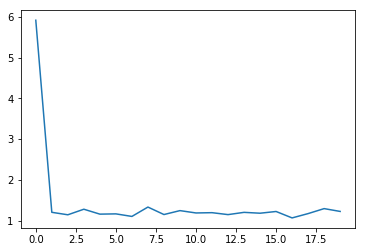

In [39]:
plt.plot(epochs_train_losses)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

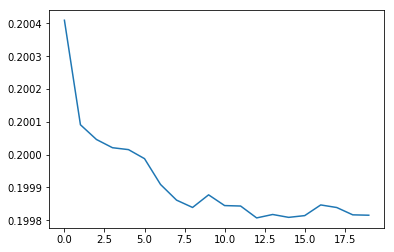

In [40]:
plt.plot(epochs_triplet_losses)
plt.show